# Setup - defining parameters that probably don't need to be changed

In [1]:

############Centroiding Parametesr###############

#thresholds for spot detection (*std)
findSigma=50     #sigma of threshold for finding spots
centSigma=15     #sigma of threshold for calculating moments

#other spot detection parameters - probably won't need to change
boxFind=10    #size of box for finding spots
boxCent=6     #size of box for centroiding
nmin=10       #minimum number of acceptable pixels in a spot
nmax=90       #maximum number of acceptable pixels in a spot
maxIt=20      #maximum number of iterations for centroiding

#set to non zero to override automatic fwhm determination. 
fwhmx=0
fwhmy=0


sigmaThresh = 4
threshFact = 2

##############Various Flags####################

#inter = 1 for notebook, 0 for scripts, cenFlag='local' for local, 'db' to read from database
inter=1
cenFlag='local'
#cenFlag='db'

#dataSource - set to 'pinhole' for pinhole mask, 'taichung' for lab data. 

dataType='pinhole'

#conifguration for rotator center

config="oct18"

#database info - update as needed
user='pfs'
passwd='fps'
host='133.40.164.208'
dbname='pfspass'
conn=None


# Setup - importing

In [3]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sigmaclip
import sys

#kludge - need to change???
sys.path.append("/Users/karr/Science/PFS/NewCode/Code/pfs_utils/python/pfs/utils/coordinates/")
import CoordTransp
import DistortionCoefficients
from importlib import reload  #for debugging purposes

#the try/except is for using in the MHS environment, or standalone. 

try:
    import mcsActor.Visualization.mcsRoutines as mcs
except:
    import mcsRoutines as mcs

try:
    import mcsActor.Visualization.fpsRoutines as fps
except:
    import fpsRoutines as fps

try:
    import mcsActor.Visualization.visRoutines as vis
except:
    import visRoutines as vis

try:
    import mcsActor.Visualization.plotRoutines as visplot
except:
    import plotRoutines as visplot


# connect to database

In [4]:

reload(vis)
#connect to database if in DB mode
if(cenFlag=='db'):
    conn=vis.dbConnect(user=user,dbname=dbname,passwd=pfspass,host=host)
    

# parameters that change for each run

In [5]:

#set frame ID minimum and maximum values (inclusive)

frameId1=4324
#frameId2=4425
frameId2=4344

#any frames to skip (bad data, etc)
frameSkip=[]   

#source directory data files in local mode
sourceDir="/Volumes/Vaal/Commissioning Run/2018-10-25/"

#subtitle for plots - first frame ID plus tag
stitle=" ["+str(frameId1).zfill(4)+"] (newcode)"

fPref="PFSC"
#get various file name inforamtion
files,prefix,centroidFile,frameIDs=vis.getFileNames(frameId1,frameId2,frameSkip,sourceDir,fPref,dataType)

nfiles=len(files)
print("Read "+str(len(files))+" files names. First = "+str(frameId1)+" Last="+str(frameId2))
print("prefix="+prefix+" centroidFile="+centroidFile)


Read 21 files names. First = 4324 Last=4344
prefix=see_04324_04344 centroidFile=see_04324_04344_centroids.dat


# calculate threshold values and region (once per config)

In [6]:
#not needed if pulling from DB
reload(vis)
reload(mcs)

image=vis.getImage(files[0])
findThresh,centThresh,xrange,yrange=mcs.getThresh(image,'calib',sigmaThresh,threshFact,findSigma,centSigma)
        
print("Thresholds=",findThresh,centThresh)
print("Boundaries of region (x1,x2,y1,y2): ",xrange[0],xrange[1],yrange[0],yrange[1])


Thresholds= 1672.5201604148547 1094.3852265489627
Boundaries of region (x1,x2,y1,y2):  200 4106 2739 6670


# Do the centroiding for a set of database, either locally or retrieve from DB


Centroiding with Parameters:  1672.5201604148547 1094.3852265489627 0 0 10 6 10 90 20
21 Frames. Centroiding 1: 3543, 2: 3445, 3: 3445, 4: 3448, 5: 3449, 6: 3456, 7: 3456, 8: 3483, 9: 3483, 10: 3527, 11: 3528, 12: 3543, 13: 3542, 14: 3543, 15: 3542, 16: 3543, 17: 3543, 18: 3543, 19: 3543, 20: 3543, 21: 3542, 


<IPython.core.display.Javascript object>


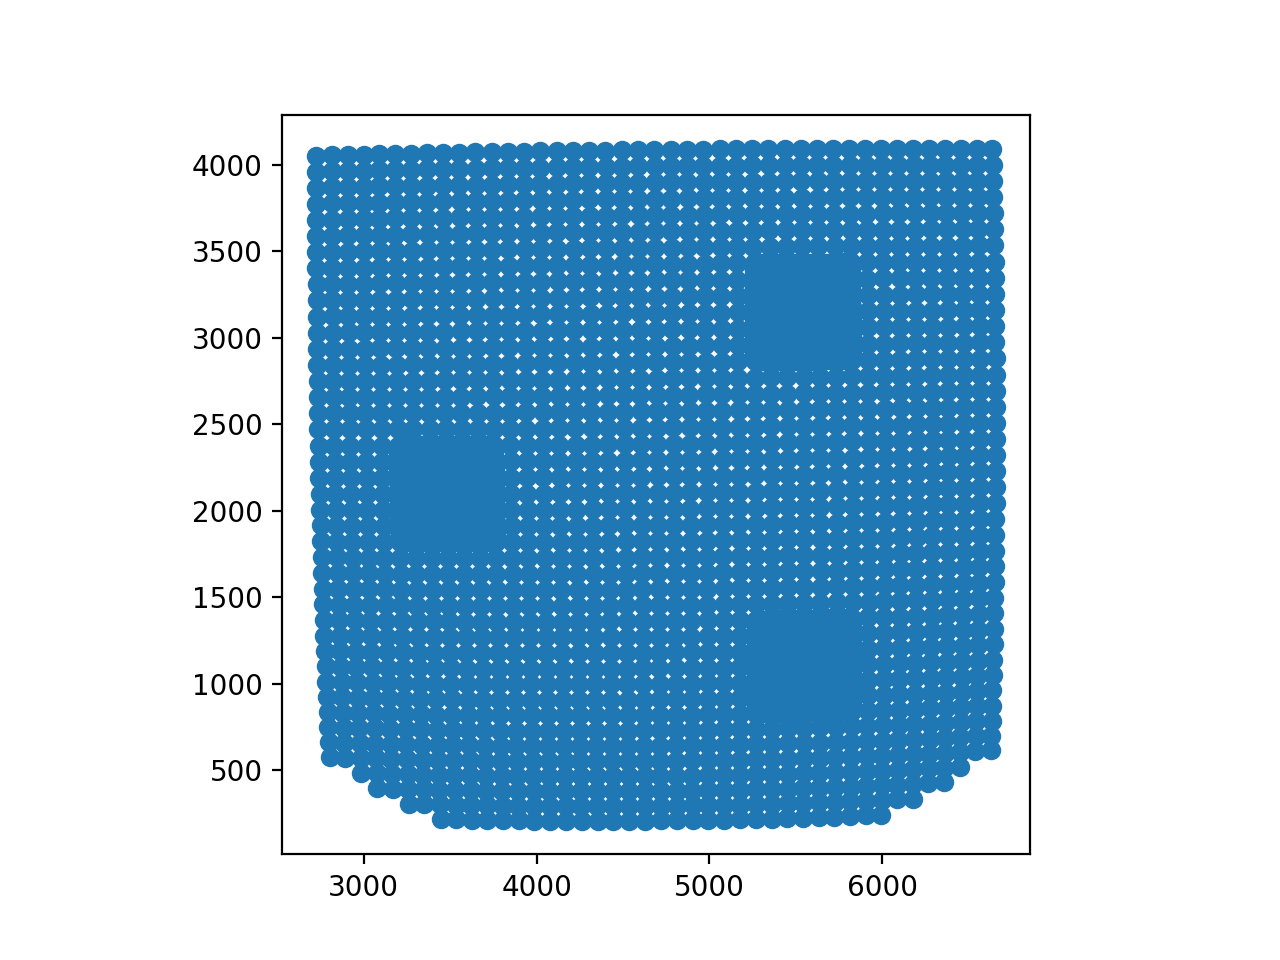

In [11]:
reload(vis)
reload(mcs)
reload(visplot)


#set redo=1 to recalculate values, redo=0 to read from files    
redo=1

#local case - either read files and calculate, or load data from a file. 
if(cenFlag=="local"):

    if(redo==1):
        print("Centroiding with Parameters: ",findThresh,centThresh,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt)
        vis.getAllCentroids(files,centroidFile,findThresh,centThresh,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt,frameIDs)
        centroids=np.loadtxt(centroidFile)
    else:
        printf("Loading Centroids from Local File.")
        centroids=np.loadtxt(centroidFile)
#db case - read from database
elif(cenFlag=='db'):
    printf("Loading Centroids from DB.")
    centroids=fps.getCentroidsDB(conn,frameIDs)        
        

#extract the first set of centroids for summary plot
ind=np.where(centroids[:,0]==frameId1)
xlast=centroids[ind,2].ravel()
ylast=centroids[ind,3].ravel()
         
visplot.checkCentroids(xlast,ylast,1,prefix,inter)


In [12]:

reload(mcs)

xCorner=[]
yCorner=[]

for i in frameIDs:
    ind=np.where(centroids[:,0]==i)
    x=centroids[ind,2].ravel()
    y=centroids[ind,3].ravel()

    x0,x1,y0,y1=mcs.getCorners(x,y)
    xCorner.append(x0)
    yCorner.append(y0)

xCorner=np.array(xCorner)
yCorner=np.array(yCorner)



<IPython.core.display.Javascript object>


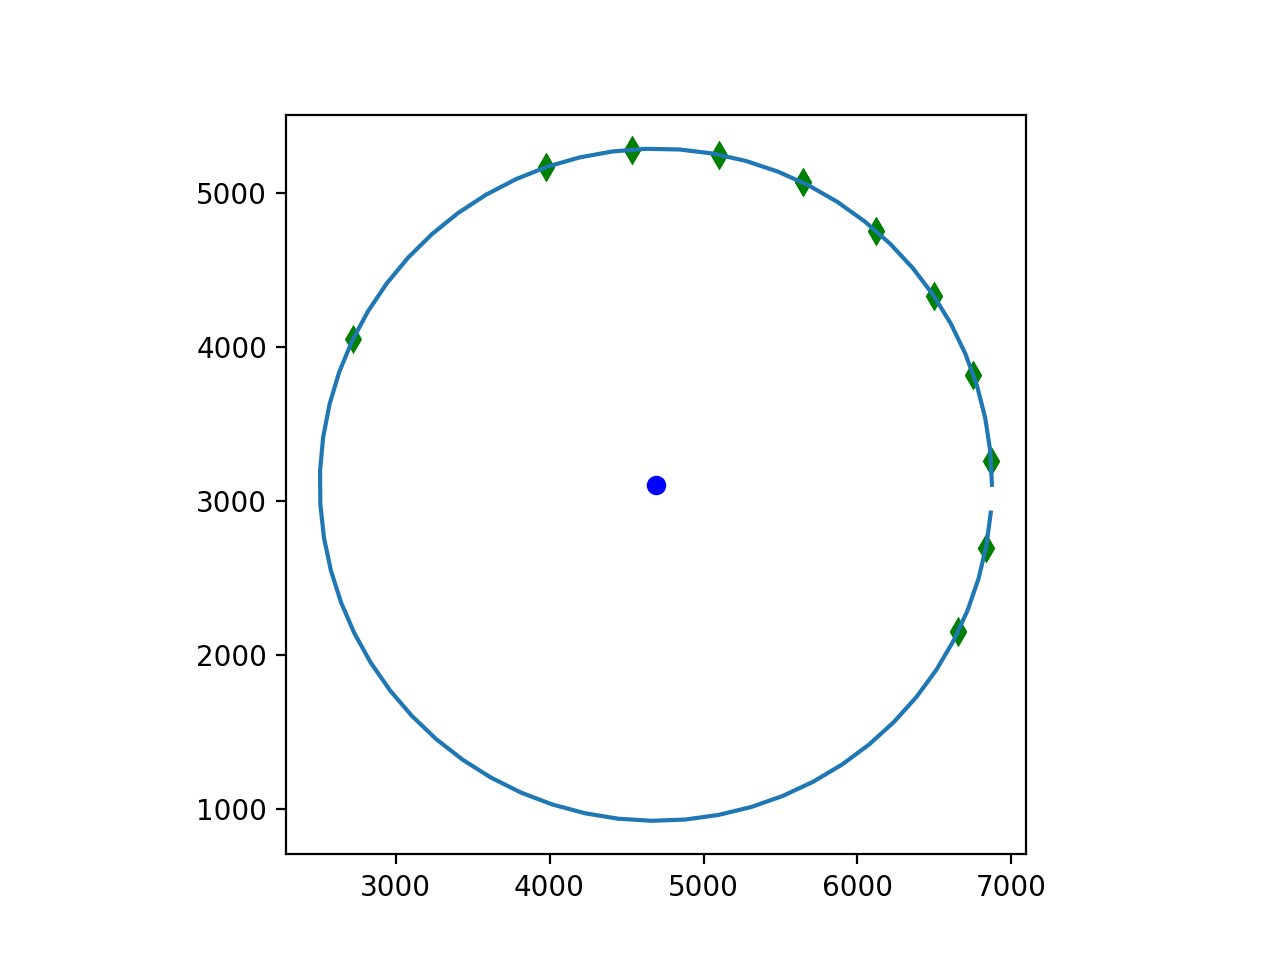

4690.43224122199 3104.562942650813 2182.9151338246356


In [14]:
reload(mcs)
fig,ax=plt.subplots()
ax.plot(xCorner,yCorner,'dg')

coords=[xCorner,yCorner]
xc,yc,r,_=fps.least_squares_circle(xCorner,yCorner)
print(xc,yc,r)

xval=[]
yval=[]
for theta in np.arange(0,2*np.pi,0.1):
    xval.append(r*np.cos(theta)+xc)
    yval.append(r*np.sin(theta)+yc)
    
ax.plot(xval,yval)
ax.plot([xc],[yc],'ob')
ax.set_aspect('equal')
plt.show()
    
